In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.sparse
import scipy.linalg

# Poisson Equation (Jacobi Iterative method)

Consider the Diriclet problem for the poisson equation in two dimension, $\textbf{x} = (x,y) \in \Omega \subset R^2$

$$
\begin{cases}
    - \Delta u(\textbf{x}) = f(\textbf{x}) \;\;\;\;\;\;\;\;\;  \textbf{x} \in \Omega \\
    u(\textbf{x}) = g(\textbf{x}) \;\;\;\;\;\;\;\;\;  \textbf{x} \in \partial \Omega
\end{cases}
$$
with
$$
 \Delta u(\textbf{x}) = \frac{\partial^2 u(\textbf{x})}{\partial x^2} + \frac{\partial^2 u(\textbf{x})}{\partial y^2}
$$

Rememembering the 5 point rule used in previous notebook

$$
  (u_{i-1,j} + u_{i,j-1} - 4u_{i,j} + u_{i,j+1} + u_{i+1,j}) = - h^2 f_{i,j}  ;\;\;\;i=1,\dots,N_x, \;\;\;\; j = 1,\dots, N_y
$$
we obtain that the update rule for the $(i,j)$-th element used in the iterative Jacobi method is

$$
  u_{i,j} =  \frac{1}{4} \left(  h^2 f_{i,j} + u_{i,j+1} + u_{i+1,j}  +u_{i-1,j} + u_{i,j-1} \right) \;\;\;\;i=1,\dots,N_x, \;\;\;\; j = 1,\dots, N_y
$$

# Implementation
## Example

Consider the following problem setting 
$$ 
\Omega = (0,1)^2,
$$

$$
f(x,y) = 8\pi sin(2\pi x)*cos(2\pi y)
$$

$$
    g(0,y) = g(1,y) = 0 
$$

$$
g(x,0) =g(x,1) = sin(2\pi x) \;\;\; 0<x<1  
$$

In [239]:
# Parameters
n_x = n_y = 20
n = n_x*n_y
a = 0
b = 1
c = 0
d = 1

# Source term
def f(x,y):
    return 8*np.pi**2*np.sin(2*np.pi*x)*np.cos(2*np.pi*y)

#def f(x,y):
    #return 2*(np.sin(2*np.pi*y) + np.cos(2*np.pi*x)) \
          # - 4*(np.pi**2)*(y**2 * np.cos(2*np.pi*x) + x**2 * np.sin(2*np.pi*y))

# Boundary terms
def g_top_bottom(x):
    return np.sin(2*np.pi*x)

def g_left_right():
    return 0

# Exact solution
def u_ex(x,y):
    return np.sin(2*np.pi*x)*np.cos(2*np.pi*y)
    #return x**2 * np.sin(2*np.pi*y) + y**2 * np.cos(2*np.pi*x)

## Define the grid

In [240]:
# Define the grid s.t. x_0 = a, x_n+1 = b, y_0 = c, y_n+1 = d
x = np.linspace(a, b, n_x+1+1)
y = np.linspace(c, d, n_y+1+1)
xv, yv = np.meshgrid(x, y)

# Set h -IMPORTANT
#h = x[1]-x[0]
h = (b-a)/(n_x+1)

## Define the boundary condition

__Important__: the boundary condition are inverted here wrt the 1.0 notebook, due the way we have numerated the discrete nodes and built the relative matrix and vector to solve the relative linear system.

In [246]:
# Set the boundary value of above defined approximated solution to the known boundary value
u_h = np.zeros((n_x+1+1,n_y+1+1))

# Left and Right boundary
for i in np.arange(n_x+2):
    u_h[i, 0] = g_top_bottom(x[i])#u_ex(x[i], y[0])#g_left_right() # Left
    u_h[i, n_y+1] = g_top_bottom(x[i]) #u_ex(x[i], y[n_y+1])#g_left_right() # Right

# Top and bottom boundary
for j in np.arange(n_y+2):
    u_h[0, j] = g_left_right() #u_ex(x[0], y[j])#g_top_bottom(x[j]) # Bottom
    u_h[n_x+1, j] = g_left_right()#u_ex(x[n_x+1], y[j])#g_top_bottom(x[j]) # Top


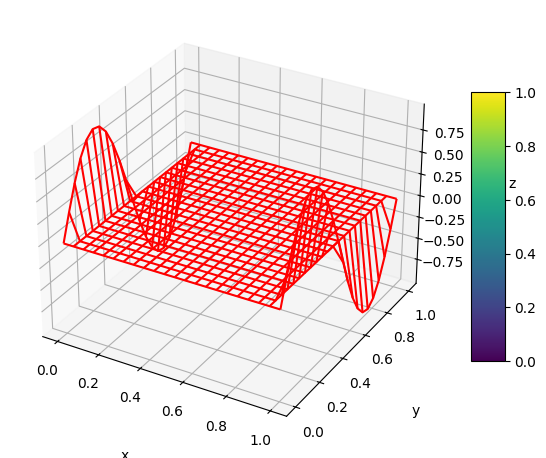

In [247]:
# Plot the boundary value
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
surf = ax.plot_wireframe(xv, yv, u_h,color='r')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

## Implement the finite difference solver

### Jacobi iterative method

In [254]:
# Parameters
max_iteration = 3000
it = 0
tolerance = 1e-3
residual_norm = 1
# History of the differences at each iteration
hist_differences = [residual_norm]
# Residuals
residuals = np.zeros((n_x+1+1,n_y+1+1))

# Initial guess - initialized to 0 in the interior node and with the right bundary condition
u_0 = np.copy(u_h) # in python variables are copied by reference! np.copy create a true copy

# Next iteration's solution
u_new = np.copy(u_0)

# Real solution
u_real = np.zeros((n_x+1+1,n_y+1+1))
for i in np.arange(0, n_x+2):
    for j in np.arange(0, n_y+2):
        u_real[i,j] = u_ex(x[i], y[j])

In [251]:
# Jacobi
while residual_norm>tolerance:
    if it > max_iteration:
        print("Solution not converged to the desired tolerence within the maximum number of iteration")
        break 

    # Modify only the interior nodes to apply Dirichlet boundary conditions
    for i in np.arange(1, n_x+1):
        for j in np.arange(1, n_y+1):
            u_new[i,j] =  0.25 * (u_0[i+1,j] + u_0[i-1,j] + u_0[i,j+1] + u_0[i,j-1] + ((h**2) * f(x[i], y[j])))

    # Calculate residual
    for i in range(1, n_x+1): # all interior combinations of i,j
        for j in range(1, n_y+1):
            residuals[i,j] = f(x[i], y[j]) - (4 * u_0[i,j] - u_new[i+1,j] - u_new[i-1,j] - u_new[i,j+1] - u_new[i,j-1]) / (h**2)
        
    # Identify residual infinity norm 
    residual_norm = np.max(np.abs(residuals))
    #print(residual_norm)

    u_0 = np.copy(u_new)

    it +=1
   
else:
    print("Reached convergence in ", it, " iterations")

Reached convergence in  379  iterations


# Results

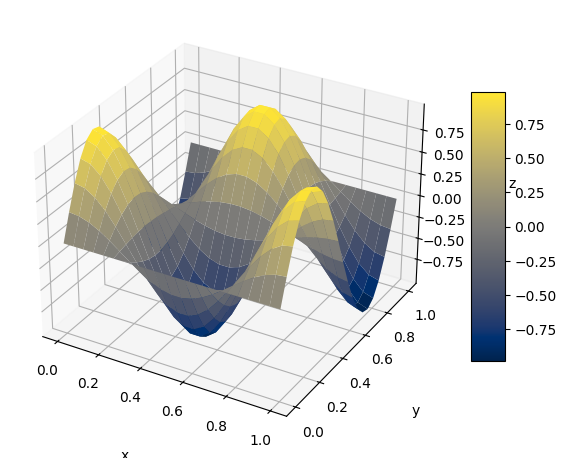

In [252]:
# Visualize the result
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xv, yv, u_new, cmap = plt.cm.cividis)


# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

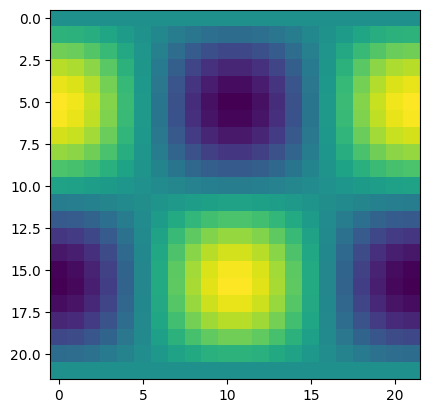

In [253]:
plt.imshow(u_new)

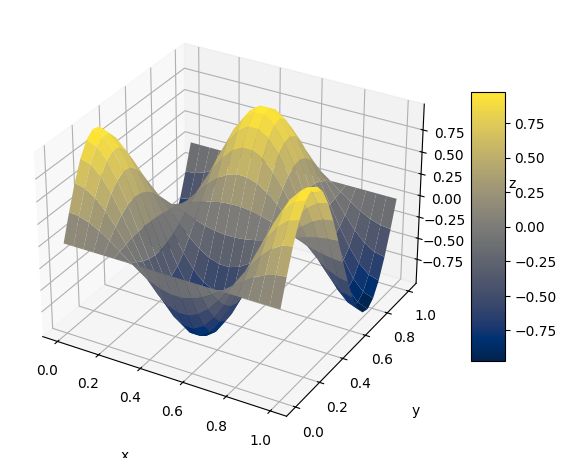

In [212]:
# plot the exact solution
z = u_real
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xv, yv, z, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

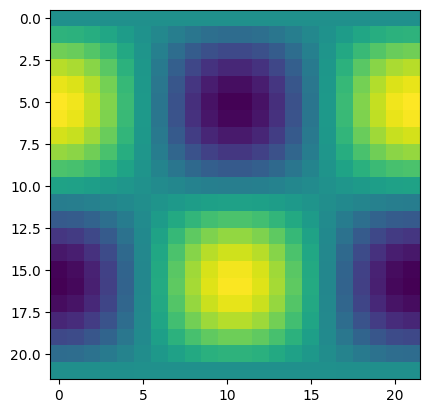

In [213]:
plt.imshow(u_real)

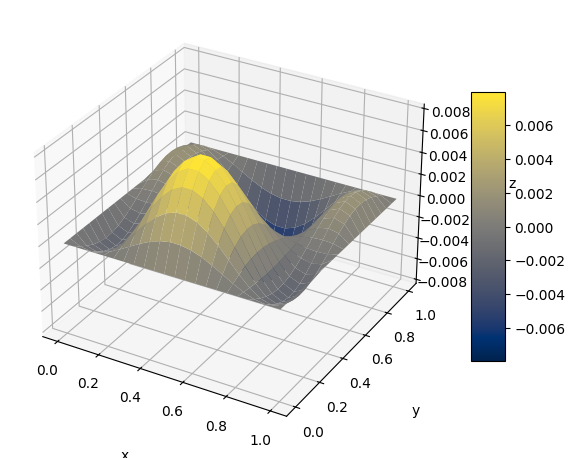

In [215]:
# Plot the error
err = u_real  - u_new
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xv, yv, err, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

# Additional code

In [217]:
# Jacobi - vectorized version
while difference>tolerance:
    if it > max_iteration:
        print("Solution not converged to the desired tolerence within the maximum number of iteration")
        break

    # Modify only the interior nodes to apply Dirichlet boundary conditions
    u_new[1:-1, 1:-1] = (u_0[:-2, 1:-1]+u_0[2:, 1:-1]+u_0[1:-1, :-2] + u_0[1:-1, 2:] - f(x[1:-1], y[1:-1])*(h**2)) / 4


    difference = np.linalg.norm(u_new - u_ex(xv,yv), ord = 2) # 2-norm: highest singolar value of the matrix
    print(difference)
    hist_differences.append(difference)

    u_0 = np.copy(u_new)

    it +=1
else:
    print("Reached convergence in ", it, " iterations")

10.98865131443341
10.98874980598031
10.98895911089595
10.98929246136916
10.98974986817861
10.990322914147491
10.99099814300753
10.991759454250296
10.992589773797402
10.9934721933558
10.994390718663732
10.99533073067845
10.99627923795702
10.99722497951721
10.99815842318194
10.999071693463518
10.999958454560382
11.00081376743228
11.001633934774826
11.002416343724791
11.003159313057463
11.003861949302237
11.004524014450965
11.005145806644157
11.005728054292724
11.006271823446381
11.006778437788164
11.007249410364766
11.007686386012377
11.008091093374647
11.008465305407043
11.008810807300945
11.009129370826296
11.009422734172478
11.00969258645534
11.009940556148242
11.010168202783063
11.010377011350219
11.010568388903913
11.010743662949176
11.010904081250159
11.011050812754881
11.011184949381189
11.011307508450797
11.011419435595721
11.01152160799269
11.011614837808427
11.011699875761348
11.01177741472448
11.011848093310743
11.011912499394812
11.011971173537203
11.0120246122851
11.01207327

# References:
- https://aquaulb.github.io/book_solving_pde_mooc/solving_pde_mooc/notebooks/05_IterativeMethods/05_01_Iteration_and_2D.html
- https://github.com/reece-iriye/Solving-2D-Poissons-Equation-Using-Finite-Difference-Method-and-Iterative-Solvers/blob/main/2D-Poisson-Implementation.ipynb